# 라이브러리

In [1]:
# 데이터 불러오기
import psycopg2
import json

# 데이터 전처리
import pandas as pd
import numpy as np
import re
import datetime

# 데이터 시각화
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import font_manager, rc
import platform

if platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
    rc('font', family='AppleGothic')

# 기타
import warnings
warnings.filterwarnings("ignore")

# 데이터 불러오기

In [2]:
#Cluster된 데이터 불러오기
import pickle
clustered = pd.read_pickle("./data/clustered_apartment.pkl")
clustered.head(5)

,apartment_id,cluster
0,1,3
1,3,3
2,4,5
3,5,5
4,6,5


In [3]:
def call_df(table_name):
    with open('config.json', 'r') as f:
        config = json.load(f)
        
    conn = psycopg2.connect(user = config['USER'],
                              password = config['PASSWORD'],
                              host = config['HOST'],
                              port = config['PORT'],
                              database = config['DATABASE'])
    
    sql = f'SELECT * FROM {table_name}'
    df = pd.read_sql_query(sql, conn)
    conn.close()
    return df

In [4]:
price = call_df('crawling_db.price_table')
price['area'] = price['area'].apply(lambda x: int(re.split('\D',x)[0]))
apartment = call_df('crawling_db.apartment_table')
apartment = apartment[['apartment_id','apartment_name']]

In [5]:
df = (apartment.
      merge(clustered, how='left', on='apartment_id').
      merge(price, how='left', on='apartment_id'))

In [6]:
df['period'] = pd.to_datetime(df['period'], format='%Y.%m')

In [7]:
df = df[['period','apartment_name','area','amount','cluster']]
df.head(5)

,period,apartment_name,area,amount,cluster
0,2020-03-01,상수두산위브,104.0,1.200000e+09,3
1,2020-02-01,상수두산위브,104.0,1.200000e+09,3
2,2019-12-01,상수두산위브,104.0,1.035000e+09,3
3,2019-11-01,상수두산위브,104.0,1.025000e+09,3
4,2019-10-01,상수두산위브,104.0,9.600000e+08,3


# 데이터 전처리

In [8]:
#사용자 옵션
user_option = {
    'apartment_name':'우남푸르미아', # 검색하고 싶은 아파트의 이름
    'apartment_area':102, # 그 아파트의 면적
}

In [9]:
#해당 cluster 찾기
group_name = df.loc[df['apartment_name'] == user_option['apartment_name'],'cluster'].values[0]
print(f"{user_option['apartment_name']} 아파트의 그룹은 {group_name}입니다.")

우남푸르미아 아파트의 그룹은 9입니다.


In [10]:
#cluster에 해당 되는 모든 아파트를 담은 dataframe
chosen_cl = df[df['cluster']==group_name]
chosen_cl

,period,apartment_name,area,amount,cluster
2201,2015-10-01,뉴현대파크빌,79.0,380000000.0,9
2202,2006-11-01,뉴현대파크빌,79.0,283000000.0,9
2203,2015-03-01,뉴현대파크빌,80.0,358000000.0,9
2204,2006-08-01,뉴현대파크빌,80.0,294000000.0,9
2205,2019-10-01,뉴현대파크빌,80.0,607000000.0,9
...,...,...,...,...,...
460231,2019-11-01,중화동양엔파트,105.0,595000000.0,9
460232,2015-03-01,중화동양엔파트,105.0,367000000.0,9
460233,2015-01-01,중화동양엔파트,105.0,367000000.0,9
460234,2014-11-01,중화동양엔파트,105.0,367000000.0,9


In [11]:
#날짜만 있는 빈 dataframe
empty = df['period'].sort_values().reset_index()
empty = empty.dropna(axis=0).drop_duplicates(['period'])

In [12]:
#사용자 옵션에 해당 하는 아파트와 면적을 지닌 dataframe
chosen = df[(df['apartment_name'] == user_option['apartment_name']) &
            (df['area'] <= user_option['apartment_area']+3) &
            (df['area'] >= user_option['apartment_area']-3)]

In [204]:
#빈 dataframe에 해당 옵션에 해당하는 dataframe을 합치면 값이 없는 곳에 na로 채워지게 된다.
temp = empty.merge(chosen,how='left',on='period')
temp.groupby(temp['period']).mean()
temp = temp.reset_index()
temp = temp[['period','amount']]

In [205]:
#처음 거래된 날짜로 부터 시작을 해본다
starting_point = temp[temp['amount'].notnull()].index[0]
ending_point = temp[temp['amount'].notnull()].index[-1]
temp = temp[starting_point:ending_point+1].reset_index()
temp = temp[['period','amount']]
temp.tail(15)

,period,amount
167,2019-01-01,NaN
168,2019-02-01,NaN
169,2019-03-01,NaN
170,2019-04-01,473000000.0
171,2019-05-01,455000000.0
172,2019-06-01,NaN
173,2019-07-01,NaN
174,2019-08-01,495000000.0
175,2019-09-01,NaN
176,2019-10-01,NaN


In [206]:
# na 값 채워주기 
for index, row in temp.iterrows():
    if np.isnan(temp['amount'][index]):
        starts = temp['amount'][index-1]
        new_index = index
        stopping = True
        while stopping:
            if np.isnan(temp['amount'][new_index+1]):
                new_index = new_index + 1
            else:
                ends = temp['amount'][new_index+1]
                stopping = False
        
        new = chosen_cl[chosen_cl['period']==temp['period'][index]]
        
        
        if starts > ends :
            groups = new[(new['amount'] <= starts) & (new['amount'] >= ends)]
        else:
            groups = new[(new['amount'] <= ends) & (new['amount'] >= starts)]
        
        if groups.empty:
            temp['amount'][index] = (starts+ends)/2
        else:
            temp['amount'][index] = groups['amount'].quantile(0.75)
        
        
        

In [207]:
temp = temp.set_index('period')
temp.tail(15)

,amount
period,
2019-01-01,4.722500e+08
2019-02-01,4.726250e+08
2019-03-01,4.728125e+08
2019-04-01,4.730000e+08
2019-05-01,4.550000e+08
2019-06-01,4.872500e+08
2019-07-01,4.945000e+08
2019-08-01,4.950000e+08
2019-09-01,5.085000e+08


# 모델링

# Arima

In [278]:
# ## 19년 12월까지의 데이터만 train하고, 나머지 20년 1~4월까지는 test하기 위해 쪼갠다
# temp_for_train = temp[0:len(temp)-4]
# temp_for_test = temp[len(temp)-4:len(temp)]

In [208]:
from pandas.plotting import autocorrelation_plot
%matplotlib inline

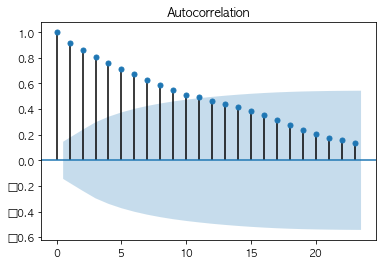

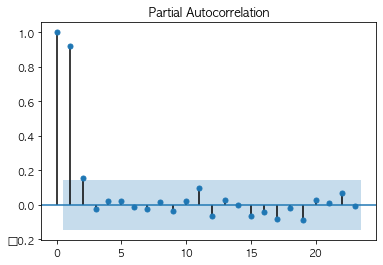

In [209]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(temp)
plot_pacf(temp)
plt.show()

AR의 경우에는 lag가 0, MR의 경우에는 lag가 급격하게 떨어지므로 1, p=0,q=1

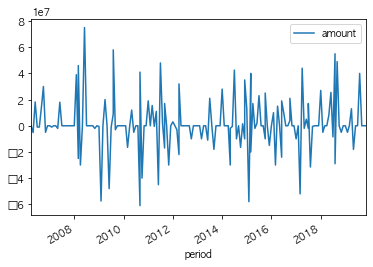

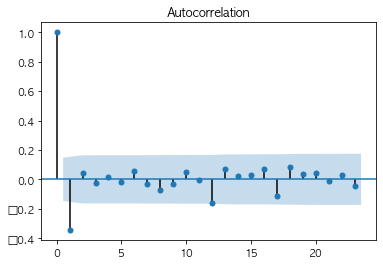

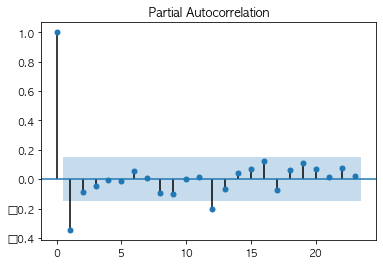

In [281]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

diff_1=temp_for_train.diff(periods=1).iloc[1:]
diff_1.plot()
plot_acf(diff_1)
plot_pacf(diff_1)
plt.show()

1차 차분이 적당하다

In [282]:
#혹시나 하여 돌려보겠습니다
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(temp_for_train, order=(0,1,1))
model_fit = model.fit(trend='c',full_output=True, disp=False)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:               D.amount   No. Observations:                  177
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -3213.307
Method:                       css-mle   S.D. of innovations       18530689.268
Date:                Thu, 04 Jun 2020   AIC                           6432.615
Time:                        17:26:30   BIC                           6442.143
Sample:                             1   HQIC                          6436.479
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1.525e+06   8.88e+05      1.717      0.086   -2.16e+05    3.27e+06
ma.L1.D.amount    -0.3642      0.068     -5.355      0.000      -0.498      -0.231
                                    

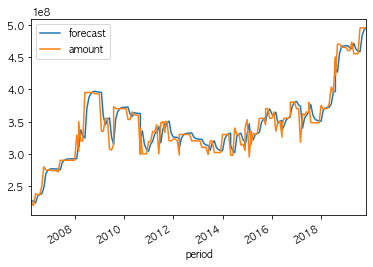

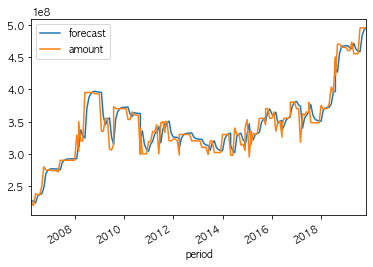

In [283]:
model_fit.plot_predict()

In [284]:
fore = model_fit.forecast(steps=4)
arima = pd.DataFrame(fore[0])
arima.columns = ['arima']
arima.index = temp_for_test.index
arima

,arima
period,
2019-12-01,4.967069e+08
2020-01-01,4.982323e+08
2020-02-01,4.997577e+08
2020-03-01,5.012831e+08


In [285]:
result = pd.concat([temp_for_test,arima],axis=1)
result.columns = ['real','model']
result

,real,model
period,,
2019-12-01,509999999.0,4.967069e+08
2020-01-01,509999999.0,4.982323e+08
2020-02-01,509999999.0,4.997577e+08
2020-03-01,542000000.0,5.012831e+08


# Auto_Arima

In [286]:
import pmdarima as pm

In [287]:
model = pm.auto_arima(temp_for_train,seasonal=True,m=12)

In [288]:
forecasts = model.predict(temp_for_test.shape[0])

In [289]:
arima = pd.DataFrame(forecasts)
arima.columns = ['arima']
arima.index = temp_for_test.index
result = pd.concat([temp_for_test,arima],axis=1)
result.columns = ['real','model']
result

,real,model
period,,
2019-12-01,509999999.0,4.980040e+08
2020-01-01,509999999.0,5.007275e+08
2020-02-01,509999999.0,5.038140e+08
2020-03-01,542000000.0,5.064166e+08


그냥 arima가 더 나은거 같기도...